In [229]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib import cm

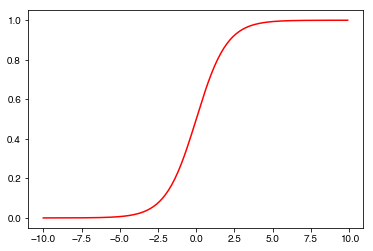

In [6]:
"""
unit defs
"""
ms = 0.001
mV = 0.001

"""
helper funcs
"""

### lowpass filter func
def lp(_in, _sp, _par=0.95):
    return _par * _in + (1 - _par) * _sp

from numpy.random import permutation
from scipy import rand, randn, ones
from scipy.sparse import csr_matrix

def _rand_sparse(m, n, density):
    # check parameters here
    if density > 1.0 or density < 0.0:
        raise ValueError('density should be between 0 and 1')
    # More checks?
    # Here I use the algorithm suggested by David to avoid ending
    # up with less than m*n*density nonzero elements (with the algorithm
    # provided by Nathan there is a nonzero probability of having duplicate
    # rwo/col pairs).
    nnz = max( min( int(m*n*density), m*n), 0)
    rand_seq = permutation(m*n)[:nnz]
    row  = rand_seq / n
    col  = rand_seq % n
    data = ones(nnz, dtype='int8')
    # duplicate (i,j) entries will be summed together
    return csr_matrix( (data,(row,col)), shape=(m,n) )

def sprand(m, n, density):
    """Build a sparse uniformly distributed random matrix
       Parameters
       ----------
       m, n     : dimensions of the result (rows, columns)
       density  : fraction of nonzero entries.
       Example
       -------
       >>> from scipy.sparse import sprand
       >>> print sprand(2, 3, 0.5).todense()
       matrix[[ 0.5724829   0.          0.92891214]
             [ 0.          0.07712993  0.        ]]
    """
    A = _rand_sparse(m, n, density)
    A.data = rand(A.nnz)
    return A

def sprandn(m, n, density, mu=0.0, var=1.0):
    """Build a sparse normally distributed random matrix
       Parameters
       ----------
       m, n     : dimensions of the result (rows, columns)
       density  : fraction of nonzero entries.
       Example
       -------
       >>> from scipy.sparse import sprandn
       >>> print sprandn(2, 4, 0.5).todense()
       matrix([[-0.84041995,  0.        ,  0.        , -0.22398594],
               [-0.664707  ,  0.        ,  0.        , -0.06084135]])
    """
    A = _rand_sparse(m, n, density)
    A.data = var*randn(A.nnz) + mu
    return A

def sig(_val):
    return 1/(1+np.exp(-_val))

#M = sprandn(100, 100, 0.1, mu=3.0, var=1.0)

In [300]:
class AnalogNet():
    def __init__(self, _N=1):
        
        ##constants
        self.func = "tanh"   # transfer function be used
        self.tau = 20 * ms   # membrane time constant
        self.stau = 1000 * ms# synaptic time constant
        self.R = 1           # membrane resistance
        self.alpha = 1.0     # input scaling
        self.Vr = -65 * mV   # resting potential
        self.eps = 0.9999    # psp time constant
        self.g = 1.0         # weight gain
        self.ssc = 1.0       # self-weight scaling
        self.N = _N
        
        ##containers
        self.V = self.Vr * np.ones(_N)
        self.I = np.zeros(_N)
        self.psp = np.zeros(_N)
        self.spk = np.zeros(_N)
        
        ## connectivity
        self.W = np.zeros((_N, _N))
        #self.W = sprandn(_N, _N, 0.01, mu=0.0, var=wsc) - 10.*wsc*np.eye(_N)
        #for i in range(_N):
        #   self.W(i,i) = 0.0
        
    
    def __len__(self):
        return self.N
    
    def reconnect(self):
        N = self.N
        wsc = self.g/np.sqrt(N)
        self.W  = wsc*randn(N,N) 
        self.W -= self.ssc*np.eye(N) + np.eye(N)*self.W
        
    
    def run(self, _inputs, _timed, VERBOSE=False):
        self.reconnect()
        dt = _timed[1]
        if VERBOSE:
            print("\n===")
            print("Simulating network of {:d} neurons for {:.2f} s (step size: {:.4f} s)".format(self.N, _timed[-1]+dt, dt))
            self.verbosep()
        
        vM = np.zeros((self.N, len(_timed)+1))
        vM[:,0] = self.V
        iM = np.zeros((self.N, len(_timed)+1))
        iM[:,0] = self.I
        pspM = np.zeros((self.N, len(_timed)+1))
        pspM[:,0] = self.psp
        for i, tstep in enumerate(_timed):
            self.step(_inputs[:,i], _dt=dt)
            vM[:,i+1] = self.V
            iM[:,i+1] = self.I
            pspM[:,i+1] = self.psp
        if VERBOSE:
            print("===\n")
        return vM, iM, pspM
        
    
    def step(self, _incurr, _dt=0.01):     
        # postsyn. response dynamics
        response = self.V - self.Vr
        dPSP = (-self.psp + response)/self.stau
        self.psp += _dt * dPSP
        
        # weighted sum of synaptic inputs
        wpsp = np.ravel(np.dot(self.W,self.psp))
        
        # net input current
        self.I = _incurr * mV  + wpsp

        #ode update
        inputV = self.alpha * self.transfer(self.R * self.I)
        dV = (self.Vr - self.V + inputV)/self.tau
        self.V += _dt*dV 
    
    def transfer(self, _val):
        if self.func is "tanh":
            return np.tanh(_val)
        if self.func is "sigm":
            return sig(_val)
        
    def verbosep(self):
        print("---")
        print("Network parameters:")
        print("---")
        print("Transfer func:\t\t", self.func)
        print("Membrane time constant:\t", self.tau/ms, "ms")
        print("Synaptic time constant:\t", self.stau/ms, "ms")
        print("Membrane resistance:\t", self.R, "ohm")
        print("Input scaling:\t\t", self.alpha)
        print("Resting potential:\t", self.Vr/mV, "mV")
        print("PSP lowpass constant:\t", self.eps)
        print("Weight gain:\t\t", self.g)
        print("Self-weight scaling:\t", self.ssc)
        print("Actual weights:\t\t", self.W)
        

In [377]:
analogNeuron = AnalogNet(_N=1)
print("My net has", len(analogNeuron), "neurons.")

# sim parameters
N = len(analogNeuron)
startT = 0.
totalT = 10.
analogNeuron.tau = 
analogNeuron.g = 1.
analogNeuron.ssc = 1.
dt = 0.001
T = np.arange(0.0, totalT+dt, dt)
myInput = 0.5*(rnd.randn(N, len(T)))
nStim = np.max(1, int(N/4))
myInput[0:nStim,1000:2000] += 10.

voltage, currents, psps = analogNeuron.run(myInput, T[:-1], VERBOSE=False)
print("My net ran for", totalT, "s.")

My net has 1 neurons.
My net ran for 10.0 s.


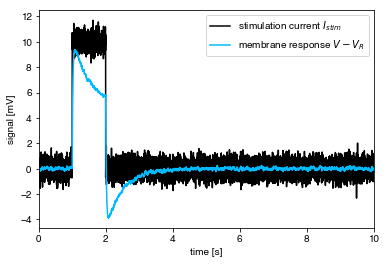

In [378]:
colors = [ cm.spring(x) for x in np.linspace(0, 1, analogNeuron.N) ]
plt.plot(T, myInput[0],"k-", label="stimulation current $I_{stim}$")
for i in range(1,analogNeuron.N):
    plt.plot(T, (voltage[i] - analogNeuron.Vr)/mV ,"-", c=colors[i])
plt.plot(T, (voltage[0] - analogNeuron.Vr)/mV ,"-", c="#00baff", label="membrane response $V-V_R$")
#plt.plot(T, psps[0]/mV ,"-", c="#FF4500", label="PSP")
#plt.plot(T, currents[0]/mV,"-", c="#FF4500", label="input current")
plt.xlabel("time [s]")
plt.ylabel("signal [mV]")
plt.legend()
plt.xlim([startT,totalT])
plt.show()

In [305]:
maxIt = 10
maxN = 2**(maxIt+4-1)
myInput = 0.1*(rnd.randn(maxN, len(T)))
myInput[0,1000:3000] += 10.
volts = []

for n in range(maxIt):
    N = 2**(n+4)
    analogNeuron = AnalogNet(_N=N)
    print("My net has", len(analogNeuron), "neurons.")
    voltage, currents, psps = analogNeuron.run(myInput[:N], T[:-1], VERBOSE=False)
    volts.append(voltage)

My net has 16 neurons.
My net has 32 neurons.
My net has 64 neurons.
My net has 128 neurons.
My net has 256 neurons.
My net has 512 neurons.
My net has 1024 neurons.
My net has 2048 neurons.
My net has 4096 neurons.
My net has 8192 neurons.


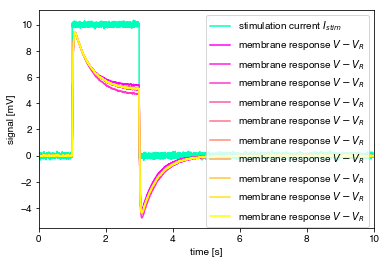

In [306]:
plt.plot(T, myInput[0],"-", c="#00ffba", label="stimulation current $I_{stim}$")
colors = [ cm.spring(x) for x in np.linspace(0, 1, len(volts)) ]
for i, volt in enumerate(volts):
    plt.plot(T, (volt[0] - analogNeuron.Vr)/mV ,"-", c=colors[i], label="membrane response $V-V_R$")

plt.xlabel("time [s]")
plt.ylabel("signal [mV]")
plt.legend()
plt.xlim([startT,totalT])
plt.show()